In [5]:
import torch
import torch.nn as nn
import torch.nn.functional as F

class VAE(nn.Module):
    def __init__(self, input_dim=784, hidden_dim=400, latent_dim=20):
        super(VAE, self).__init__()

        self.input_dim = input_dim
        self.latent_dim = latent_dim

        # --- encoder ---
        # input -> hidden
        self.fc1 = nn.Linear(input_dim, hidden_dim)
        # hidden -> latent mean (mu)
        self.fc2_mu = nn.Linear(hidden_dim, latent_dim)
        # hidden -> latent log variance (logvar)
        self.fc2_logvar = nn.Linear(hidden_dim, latent_dim)

        # --- decoder ---
        # latent -> hidden
        self.fc3 = nn.Linear(latent_dim, hidden_dim)
        # hidden -> output (reconstructed input)
        self.fc4 = nn.Linear(hidden_dim, input_dim)

    def encode(self, x):
        # pass input through first hidden layer with ReLU activation
        h = F.relu(self.fc1(x))
        # get mu and logvar
        mu = self.fc2_mu(h)
        logvar = self.fc2_logvar(h) # log-variance for numerical stability
        return mu, logvar

    def reparameterize(self, mu, logvar):
        # reparameterization trick to sample from the latent space
        std = torch.exp(0.5 * logvar)
        # sample epsilon from standard normal distribution
        eps = torch.randn_like(std)
        # compute latent variable z = mu + std * eps
        return mu + eps * std

    def decode(self, z):
        # pass latent variable through first hidden layer with ReLU
        h = F.relu(self.fc3(z))
        # output reconstructed image probabilities using sigmoid
        # sigmoid ensures output is in [0, 1] range
        return torch.sigmoid(self.fc4(h))

    def forward(self, x):
        # flatten input image for MLP layers
        x_flat = x.view(-1, self.input_dim)
        # encode to get mu and logvar
        mu, logvar = self.encode(x_flat)
        # sample latent vector z using reparameterization
        z = self.reparameterize(mu, logvar)
        # decode z to get reconstructed image
        recon_x = self.decode(z)
        # return reconstructed image, mean, and log-variance
        return recon_x, mu, logvar

def bce_kld_loss(recon_x, x, mu, logvar):
    BCE = F.binary_cross_entropy(recon_x, x.view(-1, 784), reduction='sum')
    # D_KL (N(mu, sigma^2) || N(0, I))
    # 0.5 * sum(1 + log(sigma^2) - mu^2 - sigma^2)
    # note: logvar = log(sigma^2), so sigma^2 = exp(logvar)
    KLD = -0.5 * torch.sum(1 + logvar - mu.pow(2) - logvar.exp())

    # total loss = negative ELBO = BCE + KLD
    return BCE + KLD

In [ ]:
# --- TRAINING ---
import torch
import torch.nn as nn
import torch.optim as optim
from torchvision import datasets, transforms
from torch.utils.data import DataLoader, Subset
import matplotlib.pyplot as plt
import numpy as np
import time

# --- parameters ---
INPUT_DIM = 784 # 28x28 images flattened
HIDDEN_DIM = 400
LATENT_DIM = 20
EPOCHS = 100
BATCH_SIZE = 1024
LR = 1e-3
SEED = 42
DEVICE = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

print(f"Using device: {DEVICE}")

# --- seeds ---
torch.manual_seed(SEED)
np.random.seed(SEED)
if DEVICE == torch.device('cuda'):
    torch.cuda.manual_seed(SEED)

# --- MNIST dataset (filtered for 1 and 2) ---
transform = transforms.ToTensor() # scales images to [0, 1]

train_dataset_full = datasets.MNIST(root='./data', train=True, transform=transform, download=True)
test_dataset_full = datasets.MNIST(root='./data', train=False, transform=transform, download=True)

def filter_digits(dataset, digits=[1, 2]):
    idx = torch.zeros_like(dataset.targets, dtype=torch.bool)
    for digit in digits:
        idx = idx | (dataset.targets == digit)

    indices = idx.nonzero(as_tuple=False).squeeze()
    return Subset(dataset, indices)

train_dataset = filter_digits(train_dataset_full, digits=[1, 2])
test_dataset = filter_digits(test_dataset_full, digits=[1, 2])

print(f"filtered train dataset size: {len(train_dataset)}")
print(f"filtered test dataset size: {len(test_dataset)}")

train_loader = DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True, num_workers=2, pin_memory=True)
test_loader = DataLoader(test_dataset, batch_size=BATCH_SIZE, shuffle=False, num_workers=2, pin_memory=True)

model = VAE(input_dim=INPUT_DIM, hidden_dim=HIDDEN_DIM, latent_dim=LATENT_DIM).to(DEVICE)
optimizer = optim.Adam(model.parameters(), lr=LR)

model.train()
train_losses = []
print(f"--- Training for {EPOCHS} epochs ---")
start_time = time.time()

for epoch in range(1, EPOCHS + 1):
    epoch_loss = 0
    for batch_idx, (data, _) in enumerate(train_loader):
        data = data.to(DEVICE)
        optimizer.zero_grad()

        # fwd pass
        recon_batch, mu, logvar = model(data)

        # loss
        loss = bce_kld_loss(recon_batch, data, mu, logvar)

        loss.backward()
        optimizer.step()

        epoch_loss += loss.item()

    avg_epoch_loss = epoch_loss / len(train_loader.dataset)
    train_losses.append(avg_epoch_loss)
    print(f"Epoch [{epoch}/{EPOCHS}], Average Loss: {avg_epoch_loss:.4f}")

end_time = time.time()
print(f"Training finished in {end_time - start_time:.2f} seconds.")

plt.figure(figsize=(8, 4))
plt.plot(range(1, EPOCHS + 1), train_losses, marker='o', linestyle='-')
plt.title('Average Training Loss per Epoch')
plt.xlabel('Epoch')
plt.ylabel('Average Loss')
plt.grid(True)
plt.show()
        

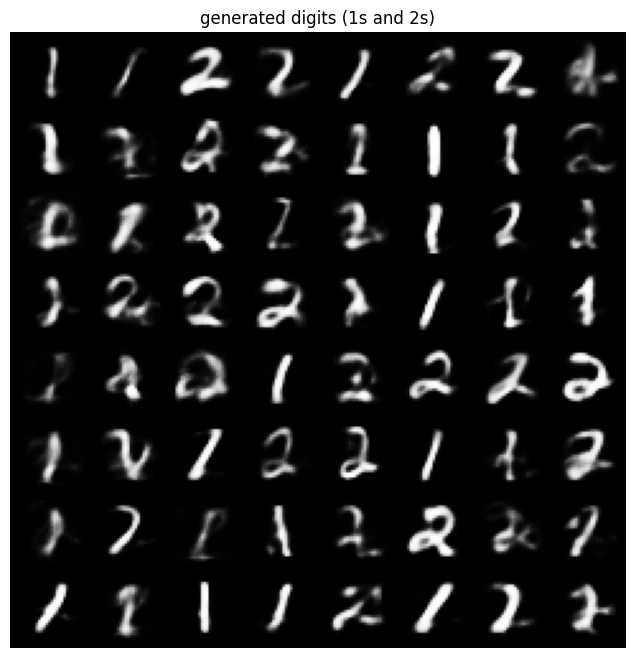

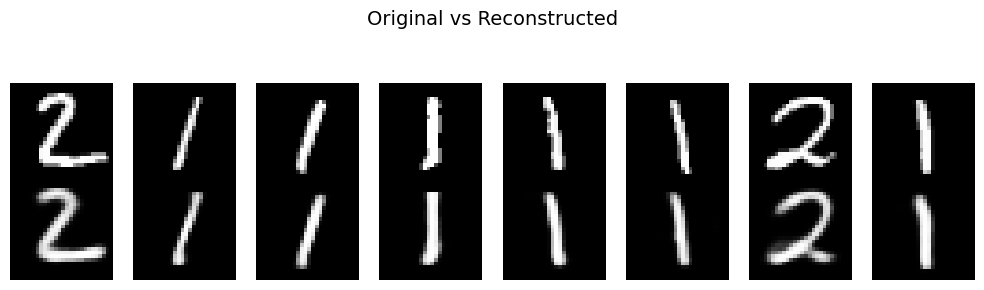

In [8]:
# --- generate samples resembling the training data ---
import matplotlib.pyplot as plt
import torchvision.utils as vutils

model.eval() # set model to evaluation mode
num_samples = 64 # no. of images to generate

with torch.no_grad():
    # sample random latent vectors from the prior N(0, 1)
    z_samples = torch.randn(num_samples, LATENT_DIM).to(DEVICE)
    # decode the latent vectors into images
    generated_images = model.decode(z_samples).cpu()

# --- visualize generated samples ---
plt.figure(figsize=(8, 8))
plt.axis("off")
plt.title("generated digits (1s and 2s)")
plt.imshow(np.transpose(vutils.make_grid(generated_images.view(num_samples, 1, 28, 28), padding=2, normalize=True), (1, 2, 0)))
plt.show()

# --- visualize reconstructions (compare input and output) ---
# get a batch from the test loader
data, _ = next(iter(test_loader))
data_cpu = data # keep a copy on CPU for plotting
data = data.to(DEVICE) # move original to GPU

model.eval()
with torch.no_grad():
    recon_batch, _, _ = model(data) # only need the reconstruction
    recon_batch = recon_batch.cpu()

n_display = 8 # display first 8 images
plt.figure(figsize=(10, 3))
plt.suptitle("Original vs Reconstructed", fontsize=14)
for i in range(n_display):
    # original
    ax = plt.subplot(2, n_display, i + 1)
    img_display = data_cpu[i].numpy().squeeze() # already [0, 1] due to ToTensor
    plt.imshow(img_display, cmap='gray')
    ax.axis('off')
    if i == 0:
        ax.set_ylabel("Original", size=10)

    # reconstructed
    ax = plt.subplot(2, n_display, i + 1 + n_display)
    recon_display = recon_batch[i].numpy().reshape(28, 28)
    plt.imshow(recon_display, cmap='gray')
    ax.axis('off')
    if i == 0:
        ax.set_ylabel("Reconstructed", size=10)

plt.tight_layout(rect=[0, 0.03, 1, 0.90])
plt.show()
